# 1 Part A

In [1]:
import numpy as np
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10,7

In [2]:
def mad_outlier(y, thresh):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    y = np.expand_dims(y, axis=1)
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [3]:
df = pd.read_csv('IVE_tickbidask.txt', delimiter = ",", names = ['date', 'time', 'price', 'bid', 'ask', 'vol'])

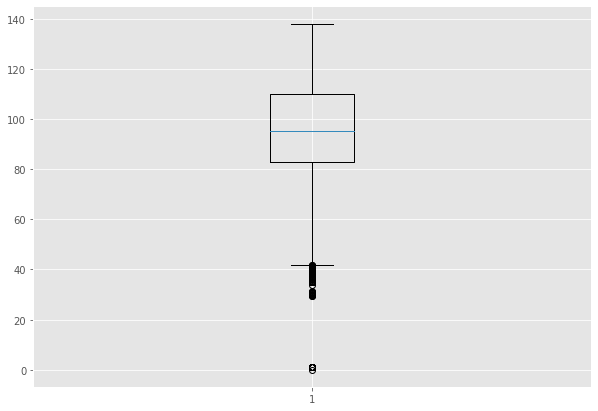

In [4]:
fig, ax = plt.subplots()
_ = ax.boxplot(df.price)

In [5]:
mad = mad_outlier(df.price.values, 2.57)
print(mad.sum())

115


In [6]:
### drop the incorrect rows
check = df.loc[~mad]

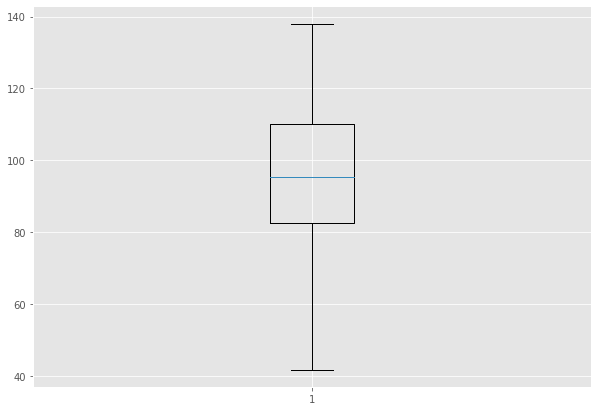

In [7]:
fig, ax = plt.subplots()
_ = ax.boxplot(check.price)

In [8]:
df = check
df['Datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df = df.set_index('Datetime')
df = df.drop(['date','time'], axis=1)
df['dollar_vol'] = df.price * df.vol

In [9]:
df

,price,bid,ask,vol,dollar_vol
Datetime,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,5075.00
2009-09-28 09:31:32,50.75,50.75,50.76,100,5075.00
2009-09-28 09:31:33,50.75,50.75,50.76,100,5075.00
...,...,...,...,...,...
2021-02-24 15:59:59,137.75,137.73,137.75,394,54273.50
2021-02-24 16:00:00,137.75,137.70,137.74,16397,2258686.75
2021-02-24 16:10:00,137.75,137.70,137.94,0,0.00


In [10]:
df_ohlc = df.price.resample('1M').ohlc()

In [11]:
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

def plot_candlestick_ohlc(df, ax, width=0.002):
    df_ohlc = df.copy()
    df_ohlc['date'] = df_ohlc.index.map(mdates.date2num)
    
    #ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
    #ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
    ax.xaxis_date()
    candlestick_ohlc(ax,
                     df_ohlc[['date','open', 'high', 'low', 'close']].values,
                     width=width,
                     colorup='g')

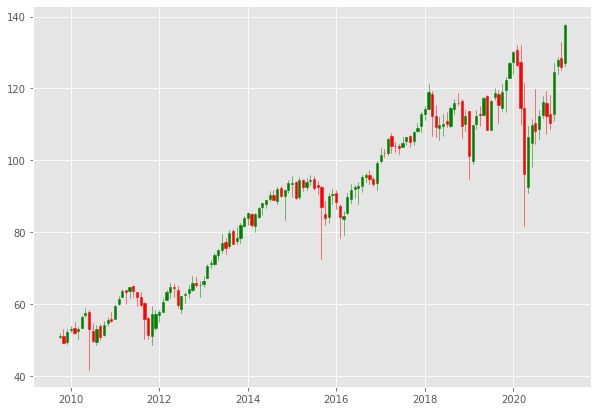

In [12]:
fig, ax = plt.subplots()
plot_candlestick_ohlc(df_ohlc, ax, width=18)

In [13]:
def tick_bar(df, m):
    return df.iloc[::m]

def volume_bar(df, m):
    aux = df.reset_index()    
    idx = []
    vol_acum = []
    c_v = 0
    for i, v in aux.vol.items():
        c_v += v 
        if c_v >= m:
            idx.append(i)
            vol_acum.append(c_v)
            c_v = 0
    volume_bar = aux.loc[idx]
    volume_bar.loc[idx, 'cum_vol'] = vol_acum 
    volume_bar = volume_bar.set_index('Datetime')
    return volume_bar

def dollar_bar(df, m):
    aux = df.reset_index()    
    idx = []
    d_acum = []
    c_dv = 0
    for i, dv in aux.dollar_vol.items():
        c_dv = c_dv + dv 
        if c_dv >= m:
            idx.append(i)
            d_acum.append(c_dv)
            c_dv = 0 
    dollar_bar = aux.loc[idx]
    dollar_bar.loc[idx, 'cum_dollar_vol'] = d_acum 
    dollar_bar = dollar_bar.set_index('Datetime')
    return dollar_bar

In [14]:
minute_df = df.price.resample('min').ohlc().dropna()

In [15]:
m = 10
tick_df = tick_bar(df, m)
tick_df

,price,bid,ask,vol,dollar_vol
Datetime,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,5079.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,5075.00
2009-09-28 09:33:08,50.82,50.80,50.83,500,25410.00
2009-09-28 09:34:58,50.80,50.78,50.80,100,5080.00
2009-09-28 09:38:32,50.81,50.81,50.82,300,15243.00
...,...,...,...,...,...
2021-02-24 15:59:43,137.86,137.85,137.86,100,13786.00
2021-02-24 15:59:47,137.86,137.85,137.86,100,13786.00
2021-02-24 15:59:53,137.83,137.81,137.83,100,13783.00


In [16]:
m = 1000
vol_df = volume_bar(df, m)
vol_df

,price,bid,ask,vol,dollar_vol,cum_vol
Datetime,,,,,,
2009-09-28 09:31:33,50.75,50.75,50.76,100,5075.00,1038
2009-09-28 09:31:50,50.75,50.73,50.76,300,15225.00,1000
2009-09-28 09:32:06,50.78,50.76,50.78,500,25390.00,1100
2009-09-28 09:33:02,50.81,50.80,50.81,300,15243.00,1000
2009-09-28 09:33:54,50.82,50.80,50.82,400,20328.00,1398
...,...,...,...,...,...,...
2021-02-24 15:59:54,137.80,137.78,137.81,300,41340.00,1000
2021-02-24 15:59:59,137.75,137.73,137.75,217,29891.75,1143
2021-02-24 15:59:59,137.75,137.73,137.75,400,55100.00,1140


In [17]:
m = 100000
dollar_df = dollar_bar(df, m)
dollar_df

,price,bid,ask,vol,dollar_vol,cum_dollar_vol
Datetime,,,,,,
2009-09-28 09:31:50,50.75,50.73,50.76,300,15225.00,1.034070e+05
2009-09-28 09:33:02,50.81,50.80,50.81,300,15243.00,1.066573e+05
2009-09-28 09:34:04,50.82,50.80,50.82,100,5082.00,1.015374e+05
2009-09-28 09:38:28,50.81,50.79,50.81,195,9907.95,1.047415e+05
2009-09-28 09:42:17,50.85,50.83,50.85,100,5085.00,1.040131e+05
...,...,...,...,...,...,...
2021-02-24 15:59:54,137.80,137.78,137.81,300,41340.00,1.240290e+05
2021-02-24 15:59:59,137.75,137.73,137.75,349,48074.75,1.275652e+05
2021-02-24 15:59:59,137.75,137.73,137.75,740,101935.00,1.318268e+05


In [18]:
print(f"{df.shape} {minute_df.shape} {tick_df.shape} {vol_df.shape} {dollar_df.shape} {tick_df.index[0]}, {tick_df.index[-1]}")

(8662071, 5) (944324, 4) (866208, 5) (1492718, 6) (1361411, 6) 2009-09-28 09:30:00, 2021-02-24 20:00:00


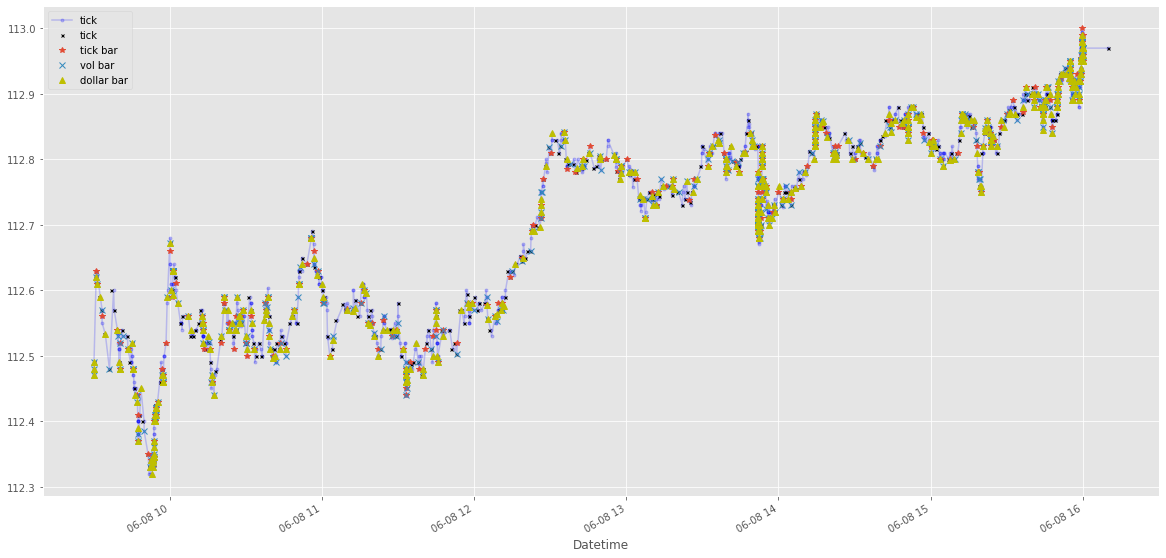

In [19]:
s_date='2018-06-08 8:00:00'
e_date='2018-06-08 17:00:00'
plt.figure(figsize=(20,10))
df.loc[s_date:e_date].price.plot(marker='o',
                                 ms=3,
                                 color='b',
                                 alpha=0.2,
                                 label='tick')

minute_df.open.loc[s_date:e_date].plot(marker='x',
                                       ms=3,
                                       ls='',
                                       color='k',
                                       label='tick')
tick_df.loc[s_date:e_date].price.plot(marker='*',
                                      ls='',
                                      label='tick bar')
vol_df.loc[s_date:e_date].price.plot(marker='x',
                                     ls='',
                                     label='vol bar')
dollar_df.loc[s_date:e_date].price.plot(marker='^',
                                        ls='',
                                        color='y',
                                        label='dollar bar')
plt.legend()

# Part B

In [20]:
weekly_tick_count = tick_df.price.resample('1W').count()
weekly_vol_count = vol_df.price.resample('1W').count()
weekly_dollar_count = dollar_df.price.resample('1W').count()

In [21]:
count_df = pd.DataFrame(columns = ['count_mean', 'count_std'], index = ['tick', 'vol', 'dollar'])
count_df.loc['tick'] = [weekly_tick_count.mean(), weekly_tick_count.std()]
count_df.loc['vol'] = [weekly_vol_count.mean(), weekly_vol_count.std()]
count_df.loc['dollar'] = [weekly_dollar_count.mean(), weekly_dollar_count.std()]
count_df

,count_mean,count_std
tick,1453.37,1056.23
vol,2504.56,1620.5
dollar,2284.25,1685.5


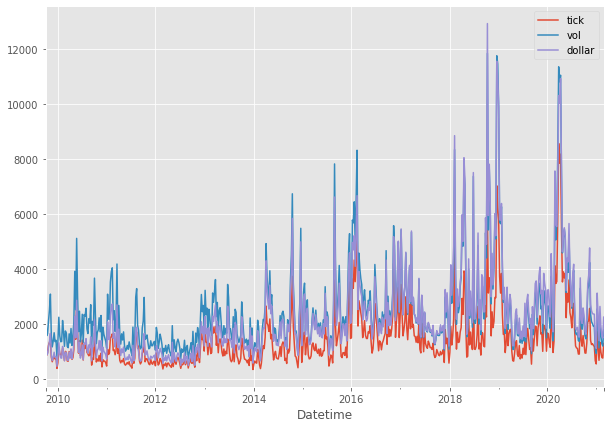

In [22]:
fig, ax = plt.subplots(1)
weekly_tick_count.plot(ax=ax)
weekly_vol_count.plot(ax=ax)
weekly_dollar_count.plot(ax=ax)
ax.legend(["tick", "vol", 'dollar'])

In [23]:
def scale(s):
    return (s-s.min())/(s.max()-s.min())

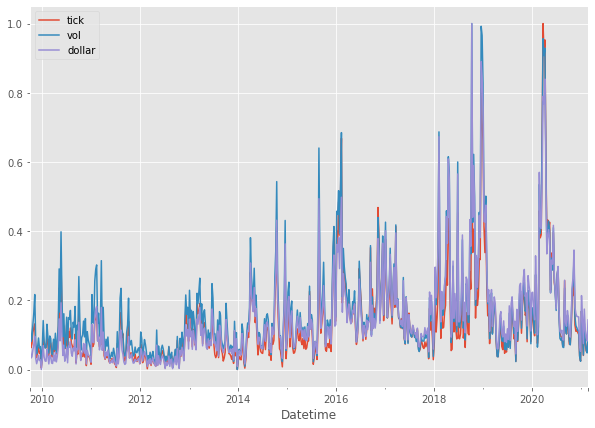

In [24]:
fig, ax = plt.subplots(1)
scale(weekly_tick_count).plot(ax=ax)
scale(weekly_vol_count).plot(ax=ax)
scale(weekly_dollar_count).plot(ax=ax)
ax.legend(["tick", "vol", 'dollar'])

# Part C

In [25]:
# log returns
tick_returns = np.log(tick_df.price).diff().dropna()
vol_returns = np.log(vol_df.price).diff().dropna()
dollar_returns = np.log(dollar_df.price).diff().dropna()

In [26]:
returns_corr_df = pd.DataFrame(data={'returns_autocorr':[tick_returns.autocorr(),  
                                                         vol_returns.autocorr(), 
                                                         dollar_returns.autocorr()]
                                    },
                               index=['tick', 'vol', 'dollar'])
returns_corr_df

,returns_autocorr
tick,-0.102409
vol,-0.071221
dollar,-0.093725


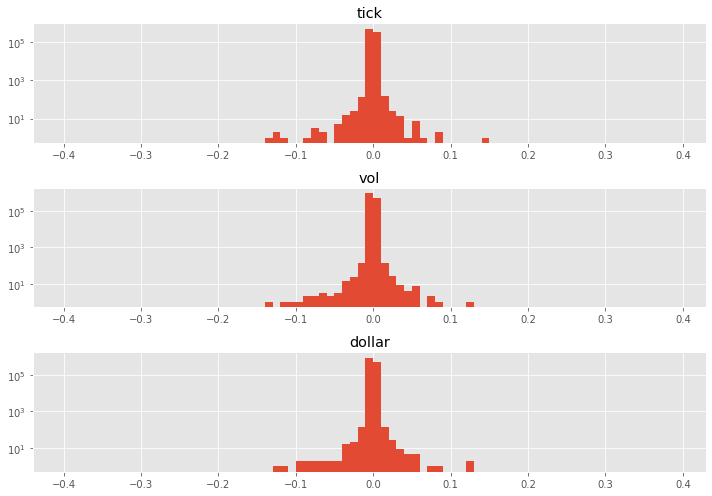

In [27]:
bins = np.arange(-0.4,0.4,0.01)
fig, ax = plt.subplots(3,1)
ax[0].hist(tick_returns, bins=bins)
ax[0].set_title('tick')
ax[1].hist(vol_returns, bins=bins)
ax[1].set_title('vol')
ax[2].hist(dollar_returns, bins=bins)
ax[2].set_title('dollar')
[a.set_yscale('log') for a in ax]
fig.tight_layout()

# Part D

In [28]:
monthly_tick_returns_var = tick_returns.resample('M').var()
monthly_vol_returns_var = vol_returns.resample('M').var()
monthly_dollar_returns_var = dollar_returns.resample('M').var()

In [29]:
monthly_ret_var_df = pd.DataFrame(data = {'monthly_returns_var' : [monthly_tick_returns_var.var(),
                                                                  monthly_vol_returns_var.var(),
                                                                  monthly_dollar_returns_var.var()]},
                                 index = ['tick', 'vol', 'dollar'])
monthly_ret_var_df

,monthly_returns_var
tick,1.842276e-12
vol,5.484466e-13
dollar,1.314341e-12


# Part E

In [30]:
from scipy.stats import jarque_bera

In [31]:
jb_value_tick, _ = jarque_bera(tick_returns)
jb_value_vol, _ = jarque_bera(vol_returns)
jb_value_dollar, _ = jarque_bera(dollar_returns)

In [32]:
jb_test_df = pd.DataFrame(data = {'jarque_bera_results' : [jb_value_tick,
                                                          jb_value_vol,
                                                          jb_value_dollar]},
                         index = ['tick', 'vol', 'dollar'])
jb_test_df

,jarque_bera_results
tick,1.423317e+12
vol,4.212182e+12
dollar,3.429727e+12


In [33]:
pd.concat([count_df, returns_corr_df, monthly_ret_var_df, jb_test_df],axis=1)

,count_mean,count_std,returns_autocorr,monthly_returns_var,jarque_bera_results
tick,1453.37,1056.23,-0.102409,1.842276e-12,1.423317e+12
vol,2504.56,1620.5,-0.071221,5.484466e-13,4.212182e+12
dollar,2284.25,1685.5,-0.093725,1.314341e-12,3.429727e+12


<AxesSubplot:ylabel='Density'>

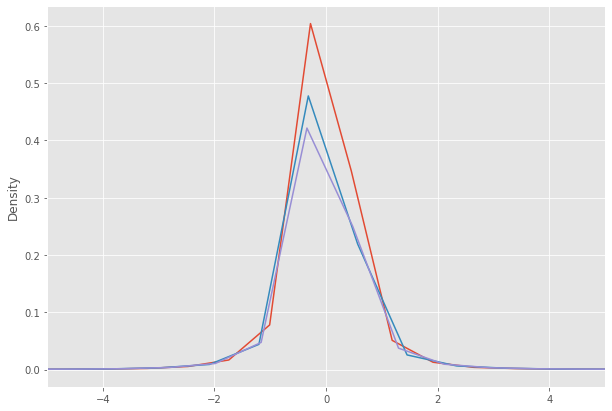

In [34]:
tick_standard = (tick_returns - tick_returns.mean()) / tick_returns.std()
volume_standard = (vol_returns - vol_returns.mean()) / vol_returns.std()
dollar_standard = (dollar_returns - dollar_returns.mean()) / dollar_returns.std()

fig, ax = plt.subplots(1,1)
tick_standard.plot.density(ax=ax,
                           xlim=(-5,5))
volume_standard.plot.density(ax=ax,
                             xlim=(-5,5))
dollar_standard.plot.density(ax=ax,
                             xlim=(-5,5))

(-5.0, 5.0)

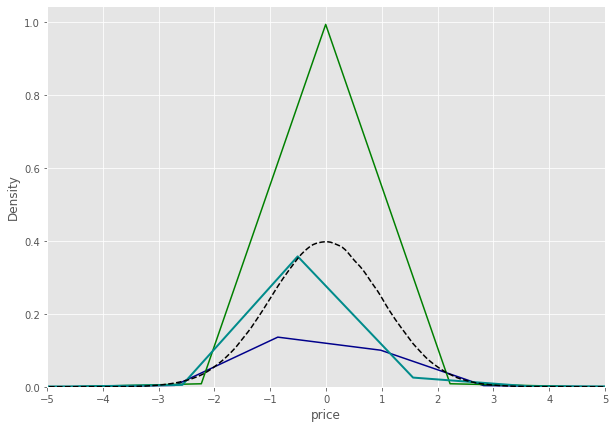

In [35]:
import seaborn as sns

fig, ax = plt.subplots()

sns.kdeplot(tick_standard, 
            ax=ax,
            label="Tick", 
            bw_method=0.25,
            color='darkblue')
sns.kdeplot(volume_standard,
            ax=ax,
            label="Volume",
            bw_method=0.25,
            color='green')
sns.kdeplot(dollar_standard,
            ax=ax,
            label="Dollar",
            bw_method=0.25,
            linewidth=2,
            color='darkcyan')
sns.kdeplot(np.random.normal(size=len(tick_standard)),
            ax=ax,
            label="Normal",
            color='black',
            linestyle="--")
ax.set_xticks(range(-5, 6))
ax.set_xlim(-5, 5)

# 2 Part A

In [36]:
def numba_isclose(a,b,rel_tol=1e-09,abs_tol=0.0):
    return np.fabs(a-b) <= np.fmax(rel_tol*np.fmax(np.fabs(a), np.fabs(b)), abs_tol)


def bt(p0, p1, bs):
    #if math.isclose((p1 - p0), 0.0, abs_tol=0.001):
    if numba_isclose((p1-p0),0.0,abs_tol=0.001):
        b = bs[-1]
        return b
    else:
        b = np.abs(p1-p0)/(p1-p0)
        return b

def get_imbalance(t):
    bs = np.zeros_like(t)
    for i in np.arange(1, bs.shape[0]):
        t_bt = bt(t[i-1], t[i], bs[:i-1])
        bs[i-1] = t_bt
    return bs[:-1] # remove last value

In [42]:
tidx = get_imbalance(df.price.values)*df.dollar_vol.iloc[1:]

In [43]:
tidx

Datetime
2009-09-28 09:30:00     -32352.98
2009-09-28 09:31:32       5075.00
2009-09-28 09:31:32       5075.00
2009-09-28 09:31:33       5075.00
2009-09-28 09:31:33       5075.00
                          ...    
2021-02-24 15:59:59      54273.50
2021-02-24 16:00:00    2258686.75
2021-02-24 16:10:00          0.00
2021-02-24 18:30:00          0.00
2021-02-24 20:00:00          0.00
Name: dollar_vol, Length: 8662070, dtype: float64

In [44]:
wndo = tidx.shape[0]//1000
print(f'window size: {wndo:,.2f}')

## Expected value of bs approximated by ewm
E_bs = tidx.ewm(wndo).mean() # expected `bs`

## what is E_T??? 
## in this implementation E_T is ewm of index values
E_T = pd.Series(range(tidx.shape[0]), index=tidx.index).ewm(wndo).mean()

df0 =(pd.DataFrame().assign(bs=tidx)
      .assign(E_T=E_T).assign(E_bs=E_bs)
      .assign(absMul=lambda df: df.E_T*np.abs(df.E_bs))
      .assign(absTheta=tidx.cumsum().abs()))

window size: 8,662.00


NameError: name 'cprint' is not defined

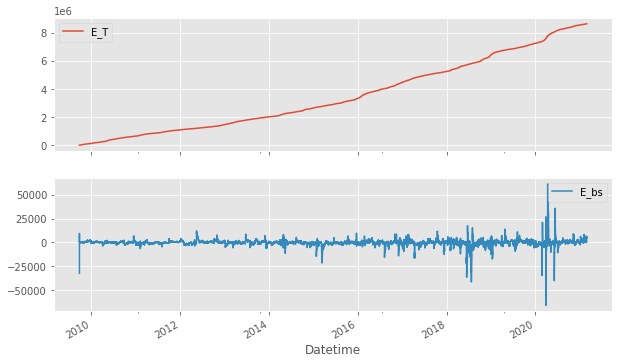

In [48]:
df0[['E_T','E_bs']].plot(subplots=True, figsize=(10,6));

<AxesSubplot:>

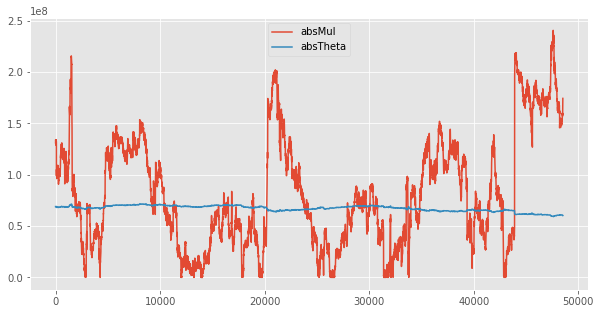

In [49]:
(df0.loc['2010-06',['absMul','absTheta']]
 .reset_index(drop=True)
 .plot(figsize=(10,5)))

In [50]:
def test_t_abs(absTheta,t,E_bs):
    """
    Bool function to test inequality
    *row is assumed to come from df.itertuples()
    -absTheta: float(), row.absTheta
    -t: pd.Timestamp()
    -E_bs: float(), row.E_bs
    """
    return (absTheta >= t*E_bs)

def agg_imbalance_bars(df):
    """
    Implements the accumulation logic
    """
    start = df.index[0]  
    bars = []
    for row in df.itertuples():
        t_abs = row.absTheta
        rowIdx = row.Index
        E_bs = row.E_bs
        
        t = df.loc[start:rowIdx].shape[0]
        if t<1: t=1 # if t lt 1 set equal to 1
        if test_t_abs(t_abs,t,E_bs):
            bars.append((start,rowIdx,t))
            start = rowIdx
    return bars

In [51]:
bars = agg_imbalance_bars(df0)
test_imb_bars = (pd.DataFrame(bars,columns=['start','stop','Ts'])
                 .drop_duplicates())

NameError: name 'cprint' is not defined

<AxesSubplot:xlabel='stop'>

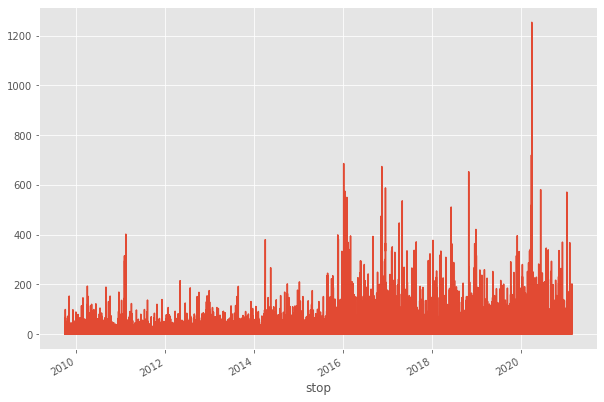

In [52]:
test_imb_bars.set_index('stop')['Ts'].plot()

In [53]:
dvImbBars = df.price.loc[test_imb_bars.stop].drop_duplicates()

In [55]:
dvBar = dollar_df.price

In [56]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

In [57]:
dr = returns(dollar_df.price)
drImb = returns(dvImbBars)

In [87]:
def get_test_stats(bar_types,bar_returns,test_func,*args,**kwds):
    
    dct = {bar:(int(bar_ret.shape[0]), test_func(bar_ret,*args,**kwds))
           for bar,bar_ret in zip(bar_types,bar_returns)}
    df = (pd.DataFrame.from_dict(dct)
          .rename(index={0:'sample_size',1:f'{test_func.__name__}_stat'})
          .T)
    return df

In [60]:
bar_types = ['dvBar','dvImb']
bar_rets = [dr, drImb]

get_test_stats(bar_types,bar_rets,pd.Series.autocorr)

,sample_size,autocorr_stat
dvBar,1361410.0,-0.093725
dvImb,352822.0,-0.015368


In [69]:
def plot_autocorr(bar_types,bar_returns):
    f,axes=plt.subplots(len(bar_types),figsize=(10,7))

    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf(bar, lags=120, ax=axes[i],
                                 alpha=0.05, adjusted=True, fft=True,
                                 zero=False,
                                 title=f'{typ} AutoCorr')
    plt.tight_layout()  

In [65]:
tr = returns(tick_df.price)
vr = returns(vol_df.price)
dr = returns(dollar_df.price)
df_ret = returns(df.price)   

bar_returns = [tr, vr, dr, df_ret]

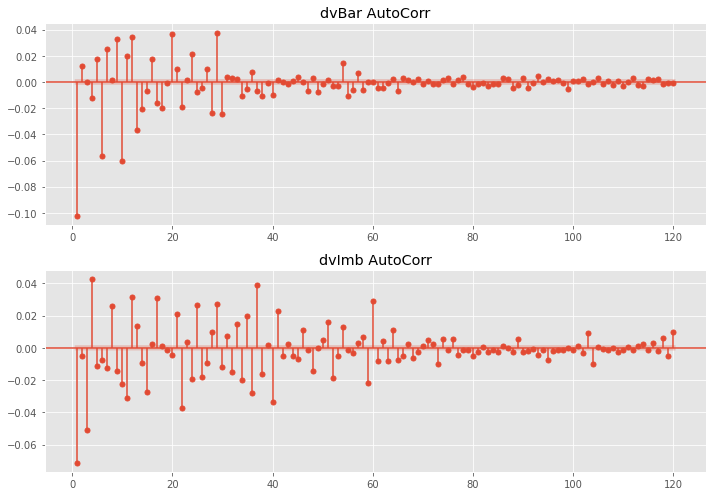

In [70]:
import statsmodels.api as sm
plot_autocorr(bar_types,bar_returns)

In [71]:
def plot_hist(bar_types,bar_rets):
    f,axes=plt.subplots(len(bar_types),figsize=(10,6))
    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        g = sns.distplot(bar, ax=axes[i], kde=False, label=typ)
        g.set(yscale='log')
        axes[i].legend()
    plt.tight_layout()

C:\Users\alane\Anaconda3\envs\wahoo\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


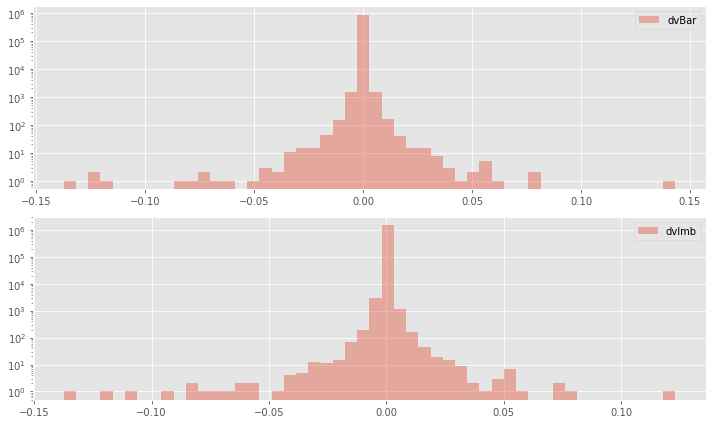

In [72]:
plot_hist(bar_types,bar_returns)

In [79]:
import scipy.stats as stats
def shapiro(x,test=True): 
    np.random.seed(12345678)
    if test: return stats.shapiro(x)[0]
    return stats.shapiro(x)[1]

(get_test_stats(bar_types,bar_returns,shapiro)
 .sort_values('shapiro_stat')[::-1])

C:\Users\alane\Anaconda3\envs\wahoo\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,sample_size,shapiro_stat
dvBar,866207.0,0.397351
dvImb,1492717.0,0.369768


In [88]:
jbs = get_test_stats(bar_types,bar_returns,jarque_bera).sort_values('jarque_bera_stat')
shaps = (get_test_stats(bar_types,bar_returns,shapiro)
         .sort_values('shapiro_stat')[::-1])

display(jbs,shaps)

,sample_size,jarque_bera_stat
dvBar,866207,"(1423316573642.9946, 0.0)"
dvImb,1492717,"(4212182377892.4097, 0.0)"


,sample_size,shapiro_stat
dvBar,866207.0,0.397351
dvImb,1492717.0,0.369768
